# Homework 6

In this homework, you will implement a multi-class Logistic Regression classifier and the SGD algorithm, and train a classifier to recognize images of digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). You will also investigate the significance of hyperparameter tuning for training and evaluation.

The purpose of this homework is to have you computing training objectives and gradients, and understand the role of regularization hyperparameter $\lambda$, learning rate $\eta$, batch size, and batch sampling techniques for training with SGD.

There are a number of programming **tasks** and **quiz questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **quiz questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

---

First, we will install the `python-mnist` [library](https://github.com/sorki/python-mnist) that provides helper functions to convert the MNIST dataset into numpy arrays.

In [ ]:
!wget -O $PWD/utils.py https://www.dropbox.com/scl/fi/jh2uwboea6jxy4qx7xk79/utils.py?rlkey=yp134mecyl97rjhanwskqcfh3&dl=1
!wget -O $PWD/linclass.py https://www.dropbox.com/scl/fi/lg1d7w15dyrave6c5nw1c/linclass.py?rlkey=crysv0fe00pq5ao2hhx9puk0x&dl=1

--2024-02-09 18:56:39--  https://www.dropbox.com/scl/fi/jh2uwboea6jxy4qx7xk79/utils.py?rlkey=yp134mecyl97rjhanwskqcfh3
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0ee73e670b783e3a9cdab98922.dl.dropboxusercontent.com/cd/0/inline/CM-56FaZL4-3M2Vo0fvrnHASTfXYp7b47oauxgNvyVpJkLxagHVUChw-PX_eE96PsIXnEaJIcqHyPL2YtRMLKrcOweI-g6X8ATl5FBbdonJINMsg-c6ufcBqpaP7i7R5Xd5Gd2tnE-YGCCnoexAtNRFW/file# [following]
--2024-02-09 18:56:41--  https://uc0ee73e670b783e3a9cdab98922.dl.dropboxusercontent.com/cd/0/inline/CM-56FaZL4-3M2Vo0fvrnHASTfXYp7b47oauxgNvyVpJkLxagHVUChw-PX_eE96PsIXnEaJIcqHyPL2YtRMLKrcOweI-g6X8ATl5FBbdonJINMsg-c6ufcBqpaP7i7R5Xd5Gd2tnE-YGCCnoexAtNRFW/file
Resolving uc0ee73e670b783e3a9cdab98922.dl.dropboxusercontent.com (uc0ee73e670b783e3a9cdab98922.dl.dropboxusercontent.com)... 162.125.13.15, 2620:10

In [ ]:
!pip install python-mnist
!pip install scikit-image

Modules `linclass` and `utils` contain several helper functions from previous homeworks such as `empirical_err()` and `create_split()`, which you might need for this homework. We encourage you to read through the relevant functions.

In [ ]:
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Tuple

import linclass
import matplotlib.pyplot as plt
import numpy as np
import utils

In [ ]:
SEED = 0
np.random.seed(SEED)

### Read MNIST Data

MNIST is a large dataset of images of handwritten digits, which can be used to train a classifier that predicts the digit (0 through 9) given a black and white image of the digit. `utils.read_MNIST` is a helper function that downloads the MNIST data to a local directory `mnist_data`, creates training, validation, and testing splits, and loads the data as numpy arrays.

MNIST has 60000 training examples and 10000 testing examples. We keep 20% of the training examples for validation, giving you 48000 training examples ultimately.

Each image is a 28 x 28 size array of ones and zeros, denoting black and white colors respectively. Let's first load the data and visualize a few images.

0% |################################################################| 100Downloaded and unzipped train-images-idx3-ubyte.gz
0% |################################################################| 100Downloaded and unzipped train-labels-idx1-ubyte.gz
0% |################################################################| 100Downloaded and unzipped t10k-images-idx3-ubyte.gz
0% |################################################################| 100Downloaded and unzipped t10k-labels-idx1-ubyte.gz
Training images
Class: 5


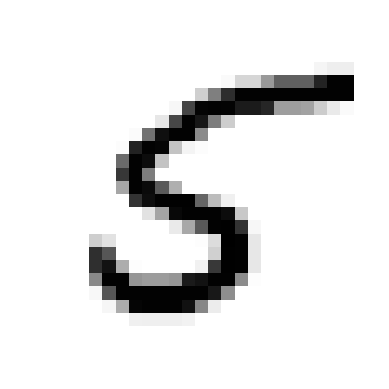

Class: 6


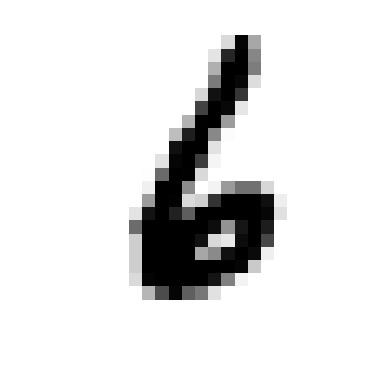

Validation images
Class: 2


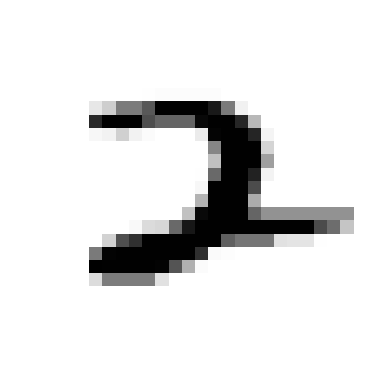

Class: 0


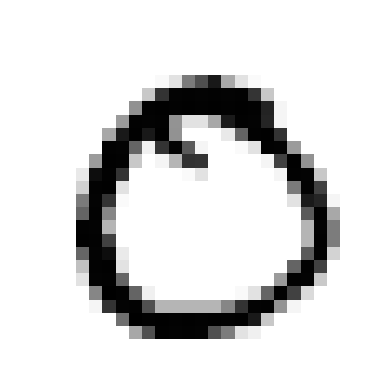

In [ ]:
X, y = utils.read_MNIST('training')
print('Training images')

print(f'Class: {y[10]}')
utils.show_MNIST_example(X[10])

print(f'Class: {y[20]}')
utils.show_MNIST_example(X[20])

X, y = utils.read_MNIST('validation')
print('Validation images')

print(f'Class: {y[10]}')
utils.show_MNIST_example(X[10])

print(f'Class: {y[20]}')
utils.show_MNIST_example(X[20])

### Feature normalization

Because gradient descent is sensitive to feature scale, we need to standardize the features (pixels of images) so that each feature has mean 0 and standard deviation 1 across the dataset. We will use the training set to estimate the mean and standard deviation of the digits, and standardize images $x$ as part of producing features $\phi(x)$.

`per_coordinate_normalized_phi` outputs a feature map that does the following transformations on an image $x \in \mathbb{R}^{d \times d}$, i.e. of width and height $d$:
1. Flatten $x$ to get a $d^2$-dimensional vector.
2. Standardize the vector representation with estimates of mean and standard deviation from the training set.
3. Apply the `base_phi` feature map. The default is `affine_phi` which adds a 1 to the beginning of the vector representation for the image for the bias parameter.

In [ ]:
def per_coordinate_normalized_phi(
    xTr: np.ndarray,
    base_phi = linclass.affine_phi,
) -> Callable[[np.ndarray], np.ndarray]:
    '''
    Returns a phi mapping that normalizes the scale of each feature using
    training data X and applies base_phi.

    Args:
        X: Data features. shape (n, ...)
        base_phi: (default linclass.affine_phi) Feature mapping to apply after normalization.

    Returns:
        phi: Function from dataset of shape (m, d') to phi mappings (m, d')
    '''
    n = xTr.shape[0]
    xTr = xTr.reshape(n, -1) # Make vectors for each data point

    # Compute normalizing stats
    mu = xTr.mean(axis=0, keepdims=True)
    sigma = xTr.std(axis=0, keepdims=True) + 1e-6

    def phi(X: np.ndarray) -> np.ndarray:
        X = X.reshape(X.shape[0], -1) # Make vectors for each data point
        X_normalized = (X - mu) / sigma
        return base_phi(X_normalized)
    return phi

We can visualize the results of applying the `per_coordinate_normalized_phi` to training images.

Before normalization


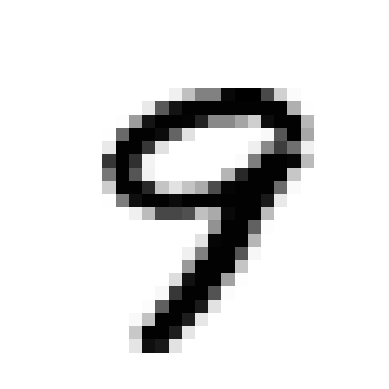

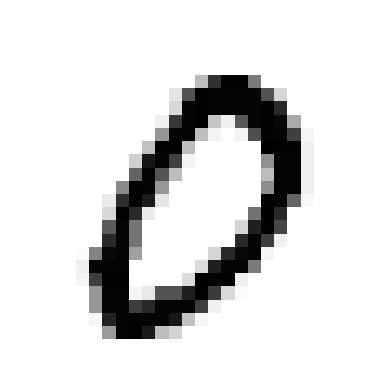

After normalization


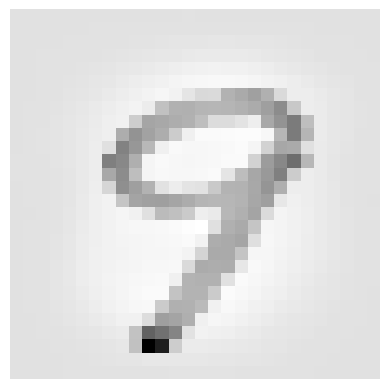

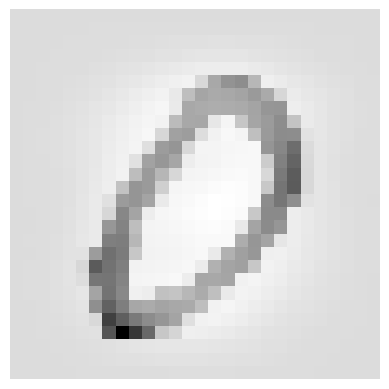

In [ ]:
xTr, yTr = utils.read_MNIST('training')
print('Before normalization')
utils.show_MNIST_example(xTr[30])
utils.show_MNIST_example(xTr[500])

norm_affine_phi = per_coordinate_normalized_phi(xTr, base_phi=linclass.affine_phi)
X = norm_affine_phi(xTr)
print('After normalization')
utils.show_MNIST_example(X[30])
utils.show_MNIST_example(X[500])

## Building a Multiclass Classifier

Now we turn to designing a multiclass classifier. Given a feature mapping $\phi : \mathcal{X} \rightarrow \mathbb{R}^d$ and data comprising of image-label pairs $(x, y) \in \mathcal{X} \times \mathcal{Y}$ where $\mathcal{Y} = \{0, \dots, 9\}$, we want to obtain a logistic regression classifier $h_w : \mathcal{X} \rightarrow \mathcal{Y} $ with parameters $w$. We will use Structural Risk Minimization (Empirical Risk Minimization with Regularization) to build a logistic regression classifier. That is,
$$
\hat{w} = \arg\min_{w} \frac{1}{m} \sum_{i=1}^m \ell^{lgst} \left( h_w \left( x_i \right), y_i \right) + \lambda R(w) \qquad \text{where } R \text{ is a regularizer}.
$$

As you have seen previously, the multiclass logistic loss (also called Cross Entropy) uses linear predictors $r_y (x) = \left\langle w_y, \phi(x) \right\rangle$ for each label $y$. The conditional probability of label $y$ given $x$ uses softmax:
$$
P (y \mid x; w) = \frac{\exp \left( r_y(x) \right)}{\sum_{y' \in \mathcal{Y}} \exp \left( r_{y'}(x)\right) }
$$
and thus the multiclass logistic loss is:
$$
\ell^{lgst} \left( h_w(x), y \right) = - \log P (y \mid x; w) = - \log \frac{\exp \left( r_y(x) \right)}{\sum_{y' \in \mathcal{Y}} \exp \left( r_{y'}(x)\right) }
$$

As we have seen before, minimizing the logistic class is equivalent to maximizing the conditional likelihood of the training set. The parameters of $h_w$ are $w = \left[ w_{y_1}, \dots, w_{y_k}\right] \in \mathbb{R}^{d \times k}$ where $k$ is the number of labels ($|\mathcal{Y}| = k$).

Having defined the multiclass linear model and the loss, we can optimize the objective using our choice of a regularizer on the parameters, such as the L2 and the L1 regularizers. These are $||w||_F^2 = \sum_{y \in \mathcal{Y}} ||w_y||_2^2$ and $\sum_{y \in \mathcal{Y}} ||w_y||_1$ respectively.

You will use Minibatch Stochastic Gradient Descent to optimize the training objective. Therefore, you will calculate the gradient of the objective w.r.t. parameters $w$ and perform gradient steps to obtain the Structural Risk Minimization solution.

### Numerical Stability

You might have noticed overflow errors in using the logistic loss in the last homework. Before proceeding to implementing the multi-class logistic loss, let us understand and prevent these errors. Our simplistic implementation of the logistic loss was:

In [ ]:
def logistic_loss(z):
    return np.log(1. + np.exp(-z))

This is mathematically correct, and works fine as long as $z$ isn't too negative.  But once $z$ is very negative, $\exp(-z)$ becomes too large and overflows:

In [ ]:
for z in [10000, 1000, 100, 10, 5, 1, -1, -5, -10, -100]:
    print(z, logistic_loss(z))

10000 0.0
1000 0.0
100 0.0
10 4.5398899216870535e-05
5 0.006715348489117967
1 0.31326168751822286
-1 1.3132616875182228
-5 5.006715348489118
-10 10.000045398899218
-100 100.0


In [ ]:
logistic_loss(-1000)

<ipython-input-8-7eab7be4902b>:2: RuntimeWarning: overflow encountered in exp
  return np.log(1. + np.exp(-z))


inf

In the last programming homework, you might have noticed that we suppressed some numpy warnings. This was to avoid divide-by-zero errors popping up when `np.log` encounters values very close to 0 and overflow errors when `np.exp` encounters value very negative (though you might have seen warnings even after we had suppressed a majority).

Thus, the problems are when:
- Computing $\log \frac{\exp y}{\exp x}$ for $x \gg y$ in fixed-precision floating point math. Although with unlimited precision the operation should exactly equal $y - x$, taking the exponent of a large number and using it as a denominator in fixed precision often rounds the fraction to 0, on which `np.log` complains.
- Computing $\exp(-z)$ when $z$ is very negative. This gets rounded off to $\infty$.

When expressions in floating-point arithmetic round to 0 due to fixed precision, they throw **underflow** errors. Likewise, when they round to $\infty$ due to fixed precision, they throw **overflow** errors.

In the last code cell, even though the intermediate calculation $\exp(1000)$ is too large, the final output after applying the log is a very sensible number, namely $-1000$.  But our implementation misses this, as it gets lost due to the exponentiation overflow. To fix this, we can implement `logistic_loss` more carefully, avoiding taking exponents of large numbers.  We do so by simplifying the logistic loss as:

$$
\log(1+e^{-z})=\log(1+e^{-z})=\log(e^{\max(0,-z)}(e^{-\max(0,-z)}+e^{-z-\max(0,-z)})=\max(0,-z)+\log(e^{\min(0,z)}+e^{\min(0,-z)}).
$$

This expression is equivalent mathematically, but note that we are only exponentiating negative numbers, and so will never have an overflow in the exponentiation.

In [ ]:
def safe_logistic_loss(z):
    return np.maximum(0, -z) + np.log(np.exp(np.minimum(0, z)) + np.exp(np.minimum(0, -z)))

We can verify that `safe_logistic_loss` returns the same answers as logistic when $z$ isn't too negative (and might also a bit more accurate and numerically stable when $z$ is very negative):

In [ ]:
for z in [10000, 1000, 100, 10, 5, 1, -1, -5, -10, -100, -500, -700, -1000]:
    print(z, logistic_loss(z), safe_logistic_loss(z))

10000 0.0 0.0
1000 0.0 0.0
100 0.0 0.0
10 4.5398899216870535e-05 4.5398899216870535e-05
5 0.006715348489117967 0.006715348489117967
1 0.31326168751822286 0.31326168751822286
-1 1.3132616875182228 1.3132616875182228
-5 5.006715348489118 5.006715348489118
-10 10.000045398899218 10.000045398899218
-100 100.0 100.0
-500 500.0 500.0
-700 700.0 700.0
-1000 inf 1000.0


<ipython-input-8-7eab7be4902b>:2: RuntimeWarning: overflow encountered in exp
  return np.log(1. + np.exp(-z))


### Numerically Stable Softmax

We will now program the softmax function:
$$
\text{softmax}(r) = \frac{\exp(r_i)}{\sum_j \exp(r_j)}.
$$

Naively, one would code `softmax(r)` on a vector `r` as the following:

```python
def softmax(r):
    # Numerically unstable!
    num = np.exp(r)
    return num / np.sum(num)
```

If one of the values in `r` was large relative to the others, `softmax` would return 0 for the others due to underflow errors, and applying `log` (to calculate the logistic loss for example) will be problematic. Therefore, we need to make `softmax` numerically stable. We do so by dividing the numerator and denominator by the largest entry in the exponentiated vector. That is,
$$
\text{softmax}(r) = \frac{\exp(r_i)}{\sum_j \exp(r_j)} = \frac{\exp(r_i) / \exp(r_{max})}{\sum_j \exp(r_j) / \exp( r_{max})} = \frac{\exp(r_i - r_{max})}{\sum_j \exp(r_j - r_{max})}.
$$

In [ ]:
def softmax(r: np.ndarray) -> np.ndarray:
    '''
    Applies the softmax operation on each row of the input, thus converting
    to normalized probabilities.

    Args:
        r: Inputs to normalize. shape (n, k)

    Returns:
        p: shape (n, k), where p[t, i] = exp(r[t, i]) / sum_j exp(r[t, j]).
    '''
    stable_num = np.exp(r - np.max(r, axis=1)[:, np.newaxis])
    return stable_num / np.sum(stable_num, axis=1)[:, np.newaxis]

### Definitions for the Classifier

Now we can proceed with defining the class structure for the classifiers. We will first define a `MultiLinearClassifier` derived from `Classifier` in the `linclass` module. The `MultiLinearClassifier` can be instantiated with a `phi` function, that applies a transformation to raw data features `X` to output a $d$-dimensional vectors for each of the inputs. The default is the affine transformation ($x \mapsto (1, x')$ where $x'$ is the vector representation of $x$).

The classifier uses the parameters $w \in \mathbb{R}^{d \times k}$ in linear prediction and picks the labels corresponding to the highest responses (we need not apply a softmax operation as it is just converts responses to probabilities without changing the relative values among predictions for different classes).

In [ ]:
class MultiLinearClassifier(linclass.Classifier):
    '''
    Multiclass predictor with k classes based on linear predictors
    in a matrix self.w, where self.w[:, j] is the predictor for class j.
    '''
    def __init__(self, phi: Callable[[np.ndarray], np.ndarray] = linclass.affine_phi):
        '''
        Args:
            phi: (default linclass.affine_phi) Function returning a feature mapping for input features.
        '''
        self.phi = phi

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Returns predicted labels for data.

        Args:
            X: Raw data features (self.phi applied before using linear prediction).
                shape (m, d')

        Returns:
            shape (m)
        '''
        return np.argmax(self.phi(X) @ self.w, axis=1)

### [Task 1] Complete the SGD training function

You will first complete the SGD implementation. `SGD` accepts the initial parameters `w0`, a gradient calculator `grad_calculator` (function from `(w, batch_idxs)` to gradient of objective w.r.t. `w`), and training parameters such as batch size, learning rate, data sampling techniques etc. We have redacted the gradient step in the heart of the implementation for you to write.

In [ ]:
@dataclass
class SGDLogger:
    '''
    Class for recording logs.

    Usage:
        ```
        # log attribute can either be given during instantiation
        # or will be populated during SGD using logging_func(w) outputs.
        SGDLogger(
            name='l2_norm_weights',
            logging_func=lambda w: np.linalg.norm(w, 'fro'),
            log=None,
            can_display=True,
            per_epoch=False
        )
        ```

    Args:
        name: Name for the logger.
        logging_func: Function from weights to some value that will be logged.
        log: (default None) Logged values.
        can_display: (default True) Flag for whether log can be printed neatly.
        per_epoch: (default False) Flag for whether logging_func(w) should
            be called per epoch in SGD method.
    '''
    name: str
    logging_func: Callable[[np.ndarray], Any] # f : w -> any
    log: Any = None # Initialize to None
    can_display: bool = True # Flag if log is displayable
    per_epoch: bool = False # Flag if logging_func should be called per epoch


def SGD(
    w0: np.ndarray,
    grad_calculator: Callable[[np.ndarray, Optional[np.ndarray]], np.ndarray],
    m: int,
    batch_size: int = 32,
    eta: float = 0.01,
    n_epochs: int = 10,
    sampling: str = 'epoch_shuffle',
    loggers: List[SGDLogger] = [],
    verbose: bool = True
) -> np.ndarray:
    '''
    Optimizes the parameters initialized at w using MiniBatch SGD on the dataset of size m
    and returns the final parameters of the classifier.

    Args:
        w0: Initial parameters for SGD. Any shape.
        grad_calculator: Function with (w, idxs) as inputs where w are parameters
            the same shape as w0 and idxs is an optional array of samples' indices,
            returning an estimate of the gradient at w based on samples with
            those indices.
        m: Size of training set.
        batch_size: (default 32) Size for mini batch.
        eta: (default 0.1) Learning rate of the MiniBatch SGD algorithm.
        n_epochs: (default 10) Number of epochs to train for.
        sampling: (default 'epoch_shuffle') one of: ['cyclic', 'randperm', 'epoch_suffle', 'iid'].
            'cycling': cycle over data in input order.
            'randperm': cycle over a random permutation of data fixed across epochs.
            'epoch_shuffle': cycle over a random permutation of data shuffled randomly every epoch.
            'iid': iid sample from the m points every epoch.
        loggers: (default []) List of SGDLoggers, the logging functions of
            which will be called during training (frequency determined by per_epoch).
        verbose: (default True) Flag to display information while training.

    Returns:
        w: shape (d, num_labels) model parameters
    '''
    assert sampling in ['cyclic', 'randperm', 'epoch_shuffle', 'iid'], 'Unknown sampling method'

    w = w0

    for logger in loggers:
        if logger.per_epoch:
            logger.log = []

    if sampling == 'randperm':
        # One random permutation for all epochs
        shuffle_idxs = np.random.permutation(m)
    elif sampling == 'cyclic':
        # Cycle over data in input order
        shuffle_idxs = np.arange(m)

    for epoch in range(n_epochs):
        if sampling == 'epoch_shuffle':
            # Sample without replacements each epoch,
            # i.e. use an independently sampled permutation each round
            shuffle_idxs = np.random.permutation(m)
        elif sampling == 'iid':
            # iid sampling, as in SGD theory
            shuffle_idxs = np.random.randint(0, high=m, size=m)
        n_batches = m // batch_size
        batch_idxs = np.array_split(shuffle_idxs, n_batches)

        # Train on mini batch
        for b in range(n_batches):
            b_idxs = batch_idxs[b] # the samples to use in this minibatch

            #### TASK 1 CODE
            g = grad_calculator(w, b_idxs) # the stochastic gradient estimate
            w = w - eta * g # gradient step
            #### TASK 1 CODE

        # Log per epoch loggers
        for logger in loggers:
            if logger.per_epoch:
                logger.log.append(logger.logging_func(w))
        if verbose:
            if epoch == 0:
                print()
            s = [f'--- Epoch: {epoch}']
            for logger in loggers:
                if logger.can_display and logger.per_epoch:
                    s.append(f'{logger.name}: {logger.log[-1]:5}')
            if len(s) > 1:
                print(', '.join(s))

    # Log final loggers
    for logger in loggers:
        if not logger.per_epoch:
            logger.log(logger.logging_func(w))
    if verbose:
        s = [f'Training complete']
        for logger in loggers:
            if logger.can_display and (not logger.per_epoch):
                s.append(f'{logger.name}: {logger.log:5}')
        if len(s) > 1:
            print(', '.join(s))

    return w

### Fitting the MultiLinearClassifier using ERM

Next we define the `ERMMultiLinearClassifier` classifier that trains the `MultiLinearClassifier` using SGD. We preserve the structural similarity with `linclass.ERMLinearClassifier` by defining `train_obj` and `train_grad` as closures that accept weights; however, we use SGD for training rather than `scipy.optimize.minimize`. `train_obj` uses a function `loss_func` that computes the loss of multiple data points, and `train_grad` uses `loss_grad` that computes the gradient w.r.t. responses $r(X) = \phi(X) w \in \mathbb{R}^{m \times k}$ ($m$ data points).

In [ ]:
class ERMMultiLinearClassifier(MultiLinearClassifier, linclass.ERMLinearClassifier):
    '''
    Multiclass predictor trained by minimizing the (regularized) empirical risk with SGD,
    w.r.t. some loss function.
    '''
    def __init__(self, lmb: float = 0., **kwargs):
        '''
        Args:
            lmb: (default 0) Regularization tradeoff prameter.
        '''
        super().__init__(**kwargs)
        self.lmb = lmb

    def fit(self, X: np.ndarray, y: np.ndarray, **sgd_kwargs):
        '''
        Fits the classifier on dataset, with self.phi applied on the data features.

        Args:
            X: Raw data features (self.phi applied before using linear prediction).
                shape (m, d')
            y: Data labels, 0 <= y_i < k. shape (m)
        '''
        phiX = self.phi(X)
        m, d = phiX.shape

        # Define training objective
        def train_obj(w: np.ndarray, batch: Optional[np.ndarray] = None) -> float:
            '''
            Calculates the training objective with parameters w on a batch of training samples.

            Args:
                w: shape (d, k), where d is the dimension of self.phi(X) and k are the number
                    of labels.
                batch: (default None) Indices of samples to calculate objective on. If None,
                    calculate objective on all samples.
            '''
            if batch is None:
                # All data is in a batch
                batch = slice(None)

            phiXbatch = phiX[batch]
            loss = np.mean(self.loss_func(phiX[batch] @ w, y[batch]))
            reg = self.regularizer(w)
            return loss + self.lmb*reg

        # Define training gradient
        def train_grad(w: np.ndarray, batch: Optional[np.ndarray] = None) -> np.ndarray:
            '''
            Returns the gradient of the training objective w.r.t. parameters w,
            calculated on a batch of training samples.

            Args:
                w: shape (d, k), where d is the dimension of self.phi(X) and k are the number
                    of labels.
                batch: (default None) Indices of samples to calculate objective on. If None,
                    calculate objective on all samples.
            '''
            if batch is None:
                # All data is in a batch
                batch = slice(None)

            phiXbatch = phiX[batch]
            b = phiXbatch.shape[0]
            loss_g = phiXbatch.T @ self.loss_grad(phiXbatch @ w, y[batch]) / b
            reg_g = self.regularizer_grad(w)
            return loss_g + self.lmb*reg_g

        k = np.max(y)+1
        w0 = np.zeros((d, k))

        self.sgd_loggers = [
            SGDLogger('train_obj', train_obj, can_display=True, per_epoch=True),
        ] + sgd_kwargs.pop('loggers', [])

        # Optimize using SGD
        self.w = SGD(
            w0,
            train_grad,
            m,
            loggers=self.sgd_loggers,
            **sgd_kwargs
        )

### [Task 2] Compute Logistic Loss and Gradient

In this task, you will complete the functions `loss_func` and `loss_grad`. Recall the logistic loss on a data point $(x_i, y_i)$:
$$
\ell^{lgst}(h_w(x_i), y_i) = - \log P(y_i \mid x_i; w) = - \log \frac{\exp \left( r_{y_i} (x_i) \right)}{\sum_{y' \in \mathcal{Y}} \exp \left( r_{y'}(x_i)\right) }
$$

- In `loss_func`, compute the logistic loss for a bunch of data points. One way would be to use `softmax` and take the log of the relevant probabilities, though `np.log` might complain (why?). The more stable way would be to simplify the expression of the logistic loss a little to obtain a more numerically stable implementation. **You should code the stable implementation of the loss.**

- In `loss_grad`, compute the gradient of the logistic los w.r.t. responses. First, write the expression for the gradient.

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

What is the gradient of $\ell^{lgst}$ w.r.t. responses $r(x)$ for one data point $x$ and its label $y$?

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer:
$$
 \frac{\partial l^{lgst}}{\partial r_{y^*}(x)} = -\mathbb{1} (y^* = y) + \frac{\exp \left( r_{y^*} (x) \right)}{\sum_{y' \in \mathcal{Y}} \exp \left( r_{y'}(x)\right) } \text{ for any } y^* \in \mathcal{Y}
$$
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

In [ ]:
class MultiLogisticReg(ERMMultiLinearClassifier):
    '''
    Multiclass predictor using Logistic Loss.
    '''
    def __init__(self, lmb: float = 0., **kwargs):
        super().__init__(lmb, **kwargs)

    def loss_func(self, responses: np.ndarray, y: np.ndarray) -> np.ndarray:
        '''
        Returns the logistic loss for each point calculated on predictor's responses against labels.

        Args:
            responses: Unnormalized responses of the predictor for each point for each label.
                shape (m, k)
            y: True labels, 0 <= y_i < k. shape (m)

        Returns:
            loss: shape (m), the logistic loss. loss[i] = -log(softmax(responses)[i, y[i]])
        '''
        #### TASK 2 CODE
        exp_responses = np.exp(responses - np.max(responses, axis=1)[:, np.newaxis])
        loss = np.log(np.sum(exp_responses, axis=1)) - \
            np.take_along_axis(exp_responses, y[:, np.newaxis], axis=1).flatten()
        #### TASK 2 CODE

        return loss

    def loss_grad(self, responses: np.ndarray, y: np.ndarray) -> np.ndarray:
        '''
        Returns the gradient of logistic loss w.r.t. responses.

        Args:
            responses: Unnormalized responses of the predictor for each point for each label.
                shape (m, k)
            y: True labels, 0 <= y_i < k. shape (m)

        Returns:
            grad: shape (m, k) where grad[t, i] is the gradient w.r.t. responses[t, i].
            grad[t, i] = grad( -log((y[t] == i)*exp(responses[t, i]) / sum_j exp(responses[t, j])) )
                = grad( -( (y[t] == i)*responses[t, i] - log(sum_j exp(responses[t, j]))) )
                = -((y[t] == i) - exp(responses[t, i]) / sum_j exp(responses[t, j]))
        '''
        m, k = responses.shape

        #### TASK 2 CODE
        probs = softmax(responses)
        grad_enum = (y[:, np.newaxis] == np.arange(k)).astype(int)
        grad_denom = probs
        grad = grad_denom - grad_enum
        #### TASK 2 CODE

        return grad

### [Task 3] Adding Regularization

Finally, we need to add regularization and its gradient. The `ERMMultiLinearClassifier.fit` method calls the `regularizer` and `regularizer_grad` functions, that you will implement. Complete the functions for both L2 and L1 regularization.

**Important:** If `is_affine_phi` is `True`, the `affine_phi` was applied to raw data features and so a constant dimension was added for the bias parameter. You should NOT include the bias parameters, which are in the first row of the parameter matrix `w`, when calculating the regularization penalty. Consequently, the gradient of the regularizer w.r.t. bias parameters should also be set to 0 if `is_affine_phi` is `True`.

In [ ]:
class MultiLogL2Reg(MultiLogisticReg):
    def __init__(self, lmb: float = 0., is_affine_phi: bool = True, **kwargs):
        '''
        Args:
            is_affine_phi: (default True) Flag determining whether argument phi
                is an affine phi (adding constant dimension to features).
                This affects the regularizer calculation as the bias parameters
                are not penalized.
        '''
        super().__init__(lmb, **kwargs)
        self.is_affine_phi = is_affine_phi

    def regularizer(self, w: np.ndarray) -> float:
        #### TASK 3 CODE
        # All rows except the first, since the first row have the bias parameters
        reg = w[1:] if self.is_affine_phi else w
        reg = np.linalg.norm(reg, 'fro')**2
        #### TASK 3 CODE

        return reg

    def regularizer_grad(self, w: np.ndarray) -> np.ndarray:
        #### TASK 3 CODE
        reg_grad = 2*w
        if self.is_affine_phi:
            reg_grad[0, :] = 0.
        #### TASK 3 CODE

        return reg_grad


class MultiLogL1Reg(MultiLogisticReg):
    def __init__(self, lmb: float = 0., is_affine_phi: bool = True, **kwargs):
        '''
        Args:
            is_affine_phi: (default True) Flag determining whether argument phi
                is an affine phi (adding constant dimension to features).
                This affects the regularizer calculation as the bias parameters
                are not penalized.
        '''
        super().__init__(lmb, **kwargs)
        self.is_affine_phi = is_affine_phi

    def regularizer(self, w: np.ndarray) -> float:
        #### TASK 3 CODE
        # All rows except the first, since the first row have the bias parameters
        reg = w[1:] if self.is_affine_phi else w
        reg = np.sum(np.abs(reg))
        return reg
        #### TASK 3 CODE

    def regularizer_grad(self, w: np.ndarray) -> np.ndarray:
        #### TASK 3 CODE
        reg_grad = np.sign(w)
        if self.is_affine_phi:
            reg_grad[0, :] = 0.
        #### TASK 3 CODE

        return reg_grad

## Training the Classifier

Having defined all relevant functions, we can now train and use the classifier. First, we will load the training and validation data and obtain `norm_affine_phi` that standardizes the raw features and applies an affine transformation (constant dimension to the feature vector).

We recommend using the small version of the training set `load_small=True` for debugging.

**Please remember to switch back to `load_small=False` and train all classifiers on the full training set before submitting.**

In [ ]:
xTr, yTr = utils.read_MNIST('training', load_small=False)
xVal, yVal = utils.read_MNIST('validation')

norm_affine_phi = per_coordinate_normalized_phi(xTr, base_phi=linclass.affine_phi)

### [Task 4] Finding the best regularization hyperparameter

We will train the Multiclass logistic classifier with L2 regularization (class `MultiLogL2Reg`) on a range of regularization hyperparameters $\lambda$.  We have defined the `tune_regularization` function and called it in the next code cell for you, so that you can see how to use the classes above.

In this task, you will find the best $\lambda$ for the logistic classifier (recall: the goal is to get a classifier that generalizes well). Also plot the training and validation errors vs $\lambda$.
- We experiment with $\lambda$ in a logarithmic range, so please use logscale on the relevant axis.
- Make sure you label your axis and provide legends in the plot!

In [ ]:
def tune_regularization(
    xTr: np.ndarray, yTr: np.ndarray, xVal: np.ndarray, yVal: np.ndarray,
    multi_logi_classifier: MultiLogisticReg,
    lmbs: List[float],
    classifier_kwargs: Dict[str, Any] = {},
    sgd_kwargs: Dict[str, Any] = {},
    verbose: bool = True,
) -> List[MultiLogisticReg]:
    '''
    Returns trained classifiers, instantiated with classifier_kwargs
    and trained with sgd_kwargs. Each trained classifier to the
    corresponding regularization hyperparameter lmb in lmbs.

    Args:
        xTr: Training raw features. shape (mTr, *)
        yTr: Training labels. shape (mTr)
        xVal: Validation raw features. shape (mVal, *)
        yVal: Validation labels. shape (mVal)
        lmbs: A list of regularization hyperparameter values (lambdas).
        multi_logi_classifier: Class name of the multiclass logistic classifier.
        classifier_kwargs: (default {}) Keyword arguments to instantiate
            multiclass logistic classifier, supplied as a dictionary.
        sgd_kwargs: (default {}) Keyword arguments for SGD training,
            supplied as a dictionary.
        verbose: (default True) Flag for printing progress.

    Returns:
        clfs: List of trained classifiers. clfs[i] classifier is trained
            with lmb=lmbs[i].
    '''
    sgd_kwargs['verbose'] = sgd_kwargs.pop('verbose', True) and verbose
    clfs = []
    for lmb in lmbs:
        if verbose:
            print(f'lambda: {lmb:.2e} ::: ', end='')

        # Train classifier
        clf = multi_logi_classifier(lmb=lmb, **classifier_kwargs)
        clf.fit(xTr, yTr, **sgd_kwargs)

        # Log train and val err
        yTr_pred = clf.predict(xTr)
        train_err = utils.empirical_err(yTr, yTr_pred)
        train_err_logger = SGDLogger(
            'train_err', None, train_err, can_display=True, per_epoch=False
        )
        clf.sgd_loggers.append(train_err_logger)

        yVal_pred = clf.predict(xVal)
        val_err = utils.empirical_err(yVal, yVal_pred)
        val_err_logger = SGDLogger(
            'val_err', None, val_err, can_display=True, per_epoch=False
        )
        clf.sgd_loggers.append(val_err_logger)

        if verbose:
            print(f'train_err: {train_err:5f}, val_err: {val_err:5f}')

        clfs.append(clf)

    return clfs

Below is the code for running the tuning experiment. Select the best model/parameters based on the hyperparameter tuning, and plot errors.

lambda: 0.00e+00 ::: train_err: 0.081875, val_err: 0.105917
lambda: 1.00e-05 ::: train_err: 0.082729, val_err: 0.107250
lambda: 1.00e-04 ::: train_err: 0.079438, val_err: 0.101167
lambda: 1.00e-03 ::: train_err: 0.100479, val_err: 0.111750
lambda: 1.00e-02 ::: train_err: 0.107375, val_err: 0.112250
lambda: 1.00e-01 ::: train_err: 0.154229, val_err: 0.161917
lambda: 1.00e+00 ::: train_err: 0.337667, val_err: 0.344167
lambda: 5.00e+00 ::: train_err: 0.538667, val_err: 0.542333
0.0001


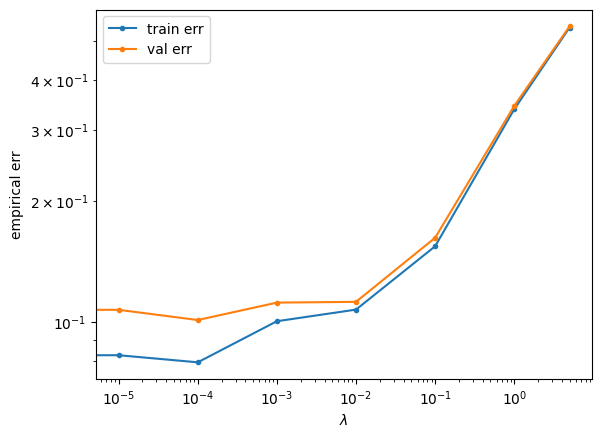

In [ ]:
# Values below are a recommendation for initial exploration -- you should see if you want to refine these
lmbs = np.sort(np.concatenate([
    np.logspace(-5, -1, 5),
    np.array([0., 1., 5.]),
]))

classifier_kwargs = {
    'phi': norm_affine_phi,
    'is_affine_phi': True,
}

# Keyword arguments for the SGD method wrapped as a dictionary, opened when calling tune_regularization
# Feel free to add to this.
sgd_kwargs = {
    'batch_size': 16,
    'n_epochs': 20,
    'eta': 0.1,
    'verbose': False, # Disable printing INSIDE SGD
}

clfs = tune_regularization(
    xTr, yTr, xVal, yVal,
    MultiLogL2Reg,
    lmbs,
    classifier_kwargs=classifier_kwargs,
    sgd_kwargs=sgd_kwargs,
    verbose=True
)

# Select best classifier
## Get logged validation errors for the trained classifiers
val_errs = [logger.log
            for clf in clfs
            for logger in clf.sgd_loggers
            if logger.name == 'val_err']
#### TASK 4 CODE
best_idx = np.argmin(val_errs)
best_lmb = lmbs[best_idx]
best_clf = clfs[best_idx]
#### TASK 4 CODE

print(best_lmb)

# Plot training and validation error w.r.t. lambda
#### TASK 4 CODE
train_errs = [logger.log
              for clf in clfs
              for logger in clf.sgd_loggers
              if logger.name == 'train_err']
#### TASK 4 CODE
plt.figure()
plt.loglog(lmbs, train_errs, marker='.', label='train err')
plt.loglog(lmbs, val_errs, marker='.', label='val err')
plt.ylabel('empirical err')
plt.xlabel('$\\lambda$')
plt.legend()
plt.show()

### [Task 5] Finding the best regularization hyperparameter for L1

In this task, you will use `tune_regularization` to find the best $\lambda$ for L1-regularized logistic classifier. As above, also plot the training and validation error vs $\lambda$.

lambda: 0.00e+00 ::: train_err: 0.077521, val_err: 0.107667
lambda: 1.00e-05 ::: train_err: 0.079312, val_err: 0.101000
lambda: 1.00e-04 ::: train_err: 0.087208, val_err: 0.106417
lambda: 1.00e-03 ::: train_err: 0.115500, val_err: 0.123417
lambda: 1.00e-02 ::: train_err: 0.168375, val_err: 0.168667
lambda: 1.00e-01 ::: train_err: 0.449083, val_err: 0.439000
lambda: 1.00e+00 ::: train_err: 0.816813, val_err: 0.818167
lambda: 5.00e+00 ::: train_err: 0.833729, val_err: 0.834250
1e-05


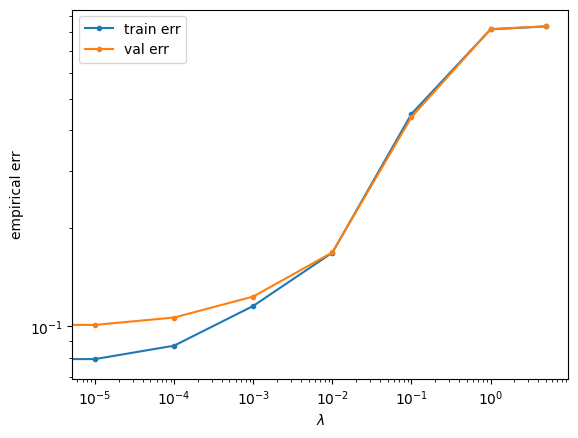

In [ ]:
#### TASK 5 CODE

clfs = tune_regularization(
    xTr, yTr, xVal, yVal,
    MultiLogL1Reg,
    lmbs,
    classifier_kwargs=classifier_kwargs,
    sgd_kwargs=sgd_kwargs,
    verbose=True
)

# Select best classifier
## Get logged validation errors for the trained classifiers
val_errs = [logger.log
            for clf in clfs
            for logger in clf.sgd_loggers
            if logger.name == 'val_err']

best_idx = np.argmin(val_errs)
best_lmb = lmbs[best_idx]
best_clf = clfs[best_idx]

print(best_lmb)

# Plot training and validation error w.r.t. lambda
train_errs = [logger.log
              for clf in clfs
              for logger in clf.sgd_loggers
              if logger.name == 'train_err']
plt.figure()
plt.loglog(lmbs, train_errs, marker='.', label='train err')
plt.loglog(lmbs, val_errs, marker='.', label='val err')
plt.ylabel('empirical err')
plt.xlabel('$\\lambda$')
plt.legend()
plt.show()

#### TASK 5 CODE

### [Task 6] Feature Normalization

Previously, we mentioned that applying normalization to features helps improve the performance of SGD optimization.
In this task, we would like to verify this idea by comparing the performance of classifiers trained with and without feature normalization.

Since feature normalization changes the magnitudes of the input data and affects the magnitudes of optimal model weights accordingly, we implement the "tune_learning_rate" method to find the best learning rate and ensure that the models are fully optimized. We also turn off regularization to simplify the experiment.

Please finish the missing code below and report the validation performance of classifiers trained with and without feature normalization.

In [ ]:
def tune_learning_rate(
    xTr: np.ndarray, yTr: np.ndarray, xVal: np.ndarray, yVal: np.ndarray,
    multi_logi_classifier: MultiLogisticReg,
    etas: List[float],
    classifier_kwargs: Dict[str, Any] = {},
    sgd_kwargs: Dict[str, Any] = {},
    verbose: bool = True,
) -> List[MultiLogisticReg]:
    '''
    Returns trained classifiers, instantiated with classifier_kwargs
    and trained with sgd_kwargs. Each trained classifier to the
    corresponding learning rate eta in etas.

    Args:
        xTr: Training raw features. shape (mTr, *)
        yTr: Training labels. shape (mTr)
        xVal: Validation raw features. shape (mVal, *)
        yVal: Validation labels. shape (mVal)
        etas: A list of learning rate values (etas).
        multi_logi_classifier: Class name of the multiclass logistic classifier.
        classifier_kwargs: (default {}) Keyword arguments to instantiate
            multiclass logistic classifier, supplied as a dictionary.
        sgd_kwargs: (default {}) Keyword arguments for SGD training,
            supplied as a dictionary.
        verbose: (default True) Flag for printing progress.

    Returns:
        clfs: List of trained classifiers. clfs[i] classifier is trained
            with eta=etas[i].
    '''
    sgd_kwargs['verbose'] = sgd_kwargs.pop('verbose', True) and verbose
    clfs = []
    for eta in etas:
        if verbose:
            print(f'eta: {eta:.2e} ::: ', end='')

        # Train classifier
        clf = multi_logi_classifier(**classifier_kwargs)
        clf.fit(xTr, yTr, eta=eta, **sgd_kwargs)

        # Log train and val err
        yTr_pred = clf.predict(xTr)
        train_err = utils.empirical_err(yTr, yTr_pred)
        train_err_logger = SGDLogger(
            'train_err', None, train_err, can_display=True, per_epoch=False
        )
        clf.sgd_loggers.append(train_err_logger)

        yVal_pred = clf.predict(xVal)
        val_err = utils.empirical_err(yVal, yVal_pred)
        val_err_logger = SGDLogger(
            'val_err', None, val_err, can_display=True, per_epoch=False
        )
        clf.sgd_loggers.append(val_err_logger)

        if verbose:
            print(f'train_err: {train_err:5f}, val_err: {val_err:5f}')

        clfs.append(clf)

    val_errs = [logger.log
        for clf in clfs
        for logger in clf.sgd_loggers
        if logger.name == 'val_err']

    train_errs = [logger.log
        for clf in clfs
        for logger in clf.sgd_loggers
        if logger.name == 'train_err']

    best_idx = np.argmin(val_errs)
    best_eta = etas[best_idx]
    best_clf = clfs[best_idx]
    best_val_err = val_errs[best_idx]

    return best_clf, best_eta, best_val_err

In [ ]:
# Values below are a recommendation for initial exploration -- you should see if you want to refine these
etas = np.logspace(-4, 0, 10)

classifier_kwargs = {
    'phi': norm_affine_phi,
    'is_affine_phi': True,
}

sgd_kwargs = {
    'batch_size': 16,
    'n_epochs': 20,
    'verbose': False,
}

best_clf, best_eta, best_val_err = tune_learning_rate(
    xTr, yTr, xVal, yVal,
    MultiLogL2Reg,
    etas,
    classifier_kwargs=classifier_kwargs,
    sgd_kwargs=sgd_kwargs,
    verbose=True
)

print(f"Best validation error trained with feature normalization: {best_val_err}")

#### TASK 6 CODE
def null_phi(x):
    return np.hstack( ( np.ones( (np.size(x,0),1) ) , x.reshape(np.size(x, 0), -1) ) )

classifier_kwargs = {
    'phi': null_phi,
    'is_affine_phi': True,
}

best_clf, best_eta, best_val_err = tune_learning_rate(
    xTr, yTr, xVal, yVal,
    MultiLogL2Reg,
    etas,
    classifier_kwargs=classifier_kwargs,
    sgd_kwargs=sgd_kwargs,
    verbose=True
)
#### TASK 6 CODE

print(f"Best validation error trained without feature normalization: {best_val_err}")

eta: 1.00e-04 ::: train_err: 0.102688, val_err: 0.107333
eta: 2.78e-04 ::: train_err: 0.088521, val_err: 0.093667
eta: 7.74e-04 ::: train_err: 0.078042, val_err: 0.083500
eta: 2.15e-03 ::: train_err: 0.069208, val_err: 0.080833
eta: 5.99e-03 ::: train_err: 0.063500, val_err: 0.079667
eta: 1.67e-02 ::: train_err: 0.060521, val_err: 0.083500
eta: 4.64e-02 ::: train_err: 0.069562, val_err: 0.095833
eta: 1.29e-01 ::: train_err: 0.079562, val_err: 0.103583
eta: 3.59e-01 ::: train_err: 0.084187, val_err: 0.114417
eta: 1.00e+00 ::: train_err: 0.090146, val_err: 0.113583
Best validation error trained with feature normalization: 0.07966666666666666
eta: 1.00e-04 ::: train_err: 0.095542, val_err: 0.114250
eta: 2.78e-04 ::: train_err: 0.114313, val_err: 0.134333
eta: 7.74e-04 ::: train_err: 0.123312, val_err: 0.135667
eta: 2.15e-03 ::: train_err: 0.110167, val_err: 0.126000
eta: 5.99e-03 ::: train_err: 0.108500, val_err: 0.121833
eta: 1.67e-02 ::: train_err: 0.096292, val_err: 0.110917
eta: 4.64e

### [Task 7] Comparing Different Sampling Strategies

In the lecture, we introduced mini-batch gradient descent.
In this task, please experiment with the four different sampling strategies for the computation of mini-batch gradients implemented in the `SGD` method.

- `cycling`: cycle over the data in the input order.
- `randperm`: cycle over a random permutation of data fixed across epochs.
- `epoch_shuffle`: cycle over a random permutation of data shuffled randomly every epoch.
- `iid`: get every batch by iid sampling of the data.

Please plot the training error of the classifiers trained with the four sampling strategies as a function of training epochs.
Do you observe significant differences between the different strategies?





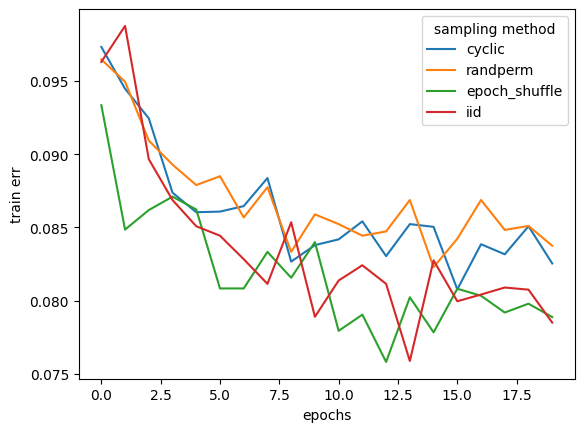

In [ ]:
classifier_kwargs = {
    'phi': norm_affine_phi,
    'is_affine_phi': True,
}

sgd_kwargs = {
    'batch_size': 16,
    'eta': 0.1,
    'n_epochs': 20,
    'verbose': False,
}

clfs = []
sampling_methods = ['cyclic', 'randperm', 'epoch_shuffle', 'iid']
#### TASK 7 CODE
def get_train_error(w):
    return utils.empirical_err(yTr, np.argmax(norm_affine_phi(xTr) @ w, axis=1))

def get_val_error(w):
    return utils.empirical_err(yVal, np.argmax(norm_affine_phi(xVal) @ w, axis=1))

for sampling_method in sampling_methods:
    sgd_kwargs['sampling'] = sampling_method

    sgd_kwargs['loggers'] = [
        SGDLogger('train_err', get_train_error, None, can_display=True, per_epoch=True),
    ]
    clf = MultiLogL2Reg(**classifier_kwargs)

    clf.fit(xTr, yTr, **sgd_kwargs)

    clfs.append(clf)

train_errs = [logger.log
            for clf in clfs
            for logger in clf.sgd_loggers
            if logger.name == 'train_err']
#### TASK 7 CODE

plt.figure()
for sampling_method, train_err in zip(sampling_methods, train_errs):
    plt.plot(np.arange(sgd_kwargs['n_epochs']), train_err, label=f'{sampling_method}')
plt.ylabel('train err')
plt.xlabel('epochs')
plt.legend(title='sampling method')
plt.show()

### [Task 8] Optimize Learning Rate for Different Batch Sizes

Recall that the formulation of mini-batch gradient descent can be written as:
$$
w_{t+1} \leftarrow w_t - \eta \frac{1}{b} \sum_{i \in B_t} \nabla_w loss(x_i, y_i, w_t)
$$
where $B_t$ represents the mini-batch sampled at time step $t$, and $b = |B_t|$ represents the batch size.
Consider the cases when we train the model for fixed epochs with different batch sizes $b_1, b_2$, where $b_2 \gg b_1$.
Since we have many fewer batches (and iterations) within one epoch when using a large batch size, it is very possible that the model can underfit if we use a fixed learning rate $\eta$.
Therefore, a simple solution is to scale up the learning rate according to the batch size by:
$$
\eta_b = \eta \cdot b
$$


In this task, please experiment with different batch sizes and use the tune_learning_rate method provided in Task 6 to find the optimal learning rate $\eta_b^*$ for different batch sizes.
You should find that the optimal learning rates roughly follow the relation $\frac{\eta_{b_1}^*}{b_1} \approx \frac{\eta_{b_2}^*}{b_2}$.


In [ ]:
classifier_kwargs = {
    'phi': norm_affine_phi,
    'is_affine_phi': True,
}

sgd_kwargs = {
    'n_epochs': 10,
    'verbose': False,
}

batch_sizes = [4, 16, 64, 256]
for batch_size in batch_sizes:
    #### TASK 8 CODE
    etas = np.logspace(-4, 0, 8)
    sgd_kwargs['batch_size'] = batch_size
    best_clf, best_eta, best_val_err = tune_learning_rate(
        xTr, yTr, xVal, yVal,
        MultiLogL2Reg,
        etas,
        classifier_kwargs=classifier_kwargs,
        sgd_kwargs=sgd_kwargs,
        verbose=True
    )
    #### TASK 8 CODE
    print(f"Batch size = {batch_size}, Best learning rate = {best_eta}")

eta: 1.00e-04 ::: train_err: 0.093000, val_err: 0.098750
eta: 3.73e-04 ::: train_err: 0.078458, val_err: 0.084500
eta: 1.39e-03 ::: train_err: 0.067854, val_err: 0.081167
eta: 5.18e-03 ::: train_err: 0.065354, val_err: 0.083917
eta: 1.93e-02 ::: train_err: 0.078729, val_err: 0.099083
eta: 7.20e-02 ::: train_err: 0.090125, val_err: 0.111250
eta: 2.68e-01 ::: train_err: 0.096354, val_err: 0.119167
eta: 1.00e+00 ::: train_err: 0.096583, val_err: 0.117750
Batch size = 4, Best learning rate = 0.0013894954943731374
eta: 1.00e-04 ::: train_err: 0.116125, val_err: 0.118083
eta: 3.73e-04 ::: train_err: 0.094125, val_err: 0.099250
eta: 1.39e-03 ::: train_err: 0.079125, val_err: 0.083917
eta: 5.18e-03 ::: train_err: 0.068750, val_err: 0.080917
eta: 1.93e-02 ::: train_err: 0.063833, val_err: 0.084583
eta: 7.20e-02 ::: train_err: 0.081125, val_err: 0.102750
eta: 2.68e-01 ::: train_err: 0.088833, val_err: 0.111833
eta: 1.00e+00 ::: train_err: 0.086437, val_err: 0.108833
Batch size = 16, Best learnin

### [Task 9] Improving Training Efficiency by Increasing Batch Sizes

The benefits of gradient descent with large batch sizes include (1) more accurate estimation of gradients and (2) improved efficiency via parallel computation.
In this task, we aim to compare the training efficiency of models trained with different batch sizes.

In the first part, we use a fixed learning rate across different batch sizes.
This setup, however, is not ideal, as we just discussed in Task 8.


In [ ]:
# With fixed learning rates
classifier_kwargs = {
    'phi': norm_affine_phi,
    'is_affine_phi': True,
}

sgd_kwargs = {
    'eta': 0.1,
    'n_epochs': 20,
    'verbose': False,
}

import time
def log_time(w):
    return time.time()

clfs = []
batch_sizes = [4, 16, 64, 256]
for batch_size in batch_sizes:
    sgd_kwargs['batch_size'] = batch_size
    clf = MultiLogL2Reg(**classifier_kwargs)
    sgd_kwargs['loggers'] = [
        SGDLogger('time', log_time, None, can_display=True, per_epoch=True),
    ]

    clf.fit(xTr, yTr, **sgd_kwargs)
    clfs.append(clf)

train_objs = [logger.log
            for clf in clfs
            for logger in clf.sgd_loggers
            if logger.name == 'train_obj']


To analyze the time consumption of training, we can use $batch\_size \times \#\ total\_batches$ as an indicator of the running time for serial computation and use $\#\ total\_batches$ to show the running time for parallel computation.
Practically, the execution of a Python program falls somewhere between the fully-serial and fully-parallel cases, so we encourage you to also compare the actual time consumption of your Python program.

Please plot the training losses with different batch sizes as a function of (1) $batch\_size \times \#\ total\_batches$, (2) $\#\ total\_batches$, and (3) execution time. In the figures, you should obviously see that the models with large batch sizes are still underfitting, as we argued in Task 8.

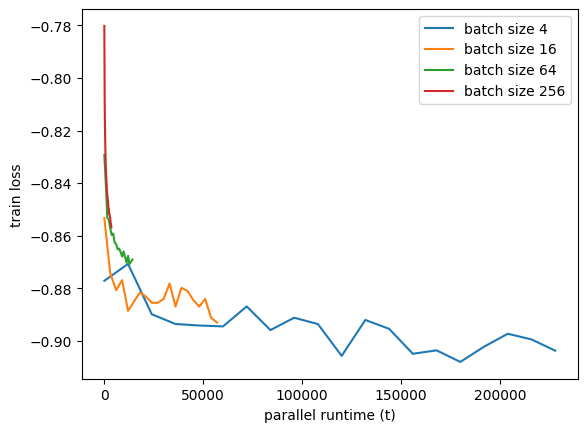

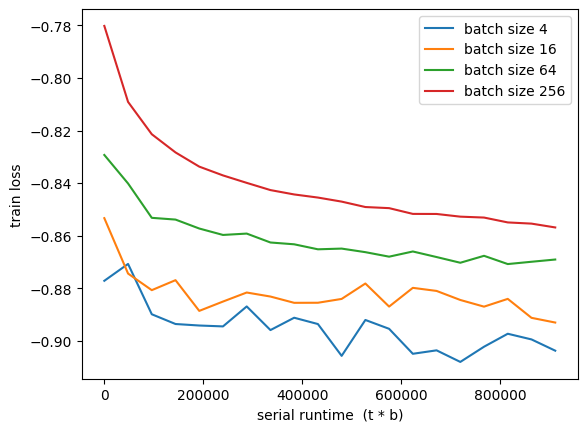

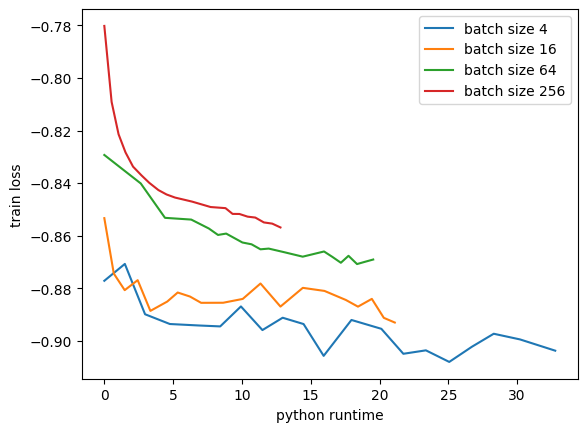

In [ ]:
plt.figure()
for batch_size, train_obj in zip(batch_sizes, train_objs):
    #### TASK 9 CODE
    plt.plot(np.arange(sgd_kwargs['n_epochs']) * (len(X) // batch_size), train_obj, label=f'batch size {batch_size}')
    #### TASK 9 CODE
plt.ylabel('train loss')
plt.xlabel('parallel runtime (t)')
plt.legend()
plt.show()

plt.figure()
for batch_size, train_obj in zip(batch_sizes, train_objs):
    #### TASK 9 CODE
    plt.plot(np.arange(sgd_kwargs['n_epochs']) * len(X), train_obj, label=f'batch size {batch_size}')
    #### TASK 9 CODE
plt.ylabel('train loss')
plt.xlabel('serial runtime  (t * b)')
plt.legend()
plt.show()

times = [logger.log
         for clf in clfs
         for logger in clf.sgd_loggers
         if logger.name == 'time']
plt.figure()
for batch_size, train_obj, time in zip(batch_sizes, train_objs, times):
    plt.plot(np.array(time)-time[0], train_obj, label=f'batch size {batch_size}')
plt.ylabel('train loss')
plt.xlabel('python runtime')
plt.legend()
plt.show()

In the second part, we'll follow the strategy outlined in Task 8 to adjust learning rates according to batch sizes.
Repeat what we did in the first part.
In the three plots, we should be able to observe that using a large batch size can achieve similar performance with much less time in the case of parallel computing.





In [ ]:
sgd_kwargs = {
    'n_epochs': 20,
    'verbose': False,
}

clfs = []
#### TASK 9 CODE
# Train the models with adjusted learning rates
for batch_size in batch_sizes:
    sgd_kwargs['batch_size'] = batch_size
    sgd_kwargs['eta'] = 0.025 * batch_size
    clf = MultiLogL2Reg(**classifier_kwargs)
    sgd_kwargs['loggers'] = [
        SGDLogger('time', log_time, None, can_display=True, per_epoch=True),
    ]

    clf.fit(xTr, yTr, **sgd_kwargs)
    clfs.append(clf)
#### TASK 9 CODE

train_objs = [logger.log
            for clf in clfs
            for logger in clf.sgd_loggers
            if logger.name == 'train_obj']

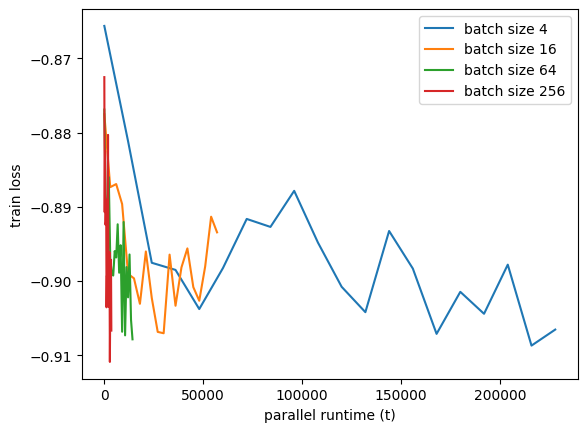

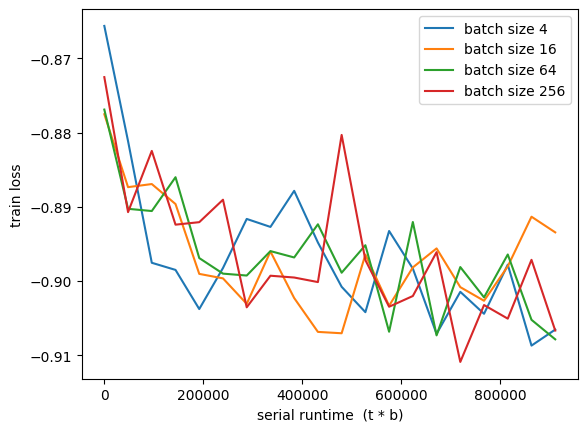

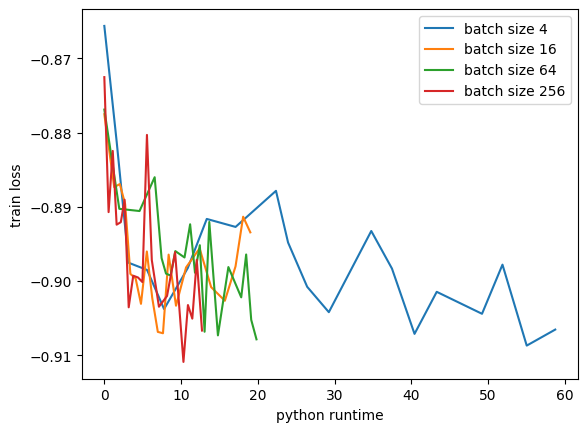

In [ ]:
plt.figure()
for batch_size, train_obj in zip(batch_sizes, train_objs):
    #### TASK 9 CODE
    plt.plot(np.arange(sgd_kwargs['n_epochs']) * (len(X) // batch_size), train_obj, label=f'batch size {batch_size}')
    #### TASK 9 CODE
plt.ylabel('train loss')
plt.xlabel('parallel runtime (t)')
plt.legend()
plt.show()

plt.figure()
for batch_size, train_obj in zip(batch_sizes, train_objs):
    #### TASK 9 CODE
    plt.plot(np.arange(sgd_kwargs['n_epochs']) * len(X), train_obj, label=f'batch size {batch_size}')
    #### TASK 9 CODE
plt.ylabel('train loss')
plt.xlabel('serial runtime  (t * b)')
plt.legend()
plt.show()

times = [logger.log
         for clf in clfs
         for logger in clf.sgd_loggers
         if logger.name == 'time']
plt.figure()
for batch_size, train_obj, time in zip(batch_sizes, train_objs, times):
    plt.plot(np.array(time)-time[0], train_obj, label=f'batch size {batch_size}')
plt.ylabel('train loss')
plt.xlabel('python runtime')
plt.legend()
plt.show()

### [Task 10] Final classifier

As the last task, train a classifier with hyperparameters of your choice.
Plot the training/validation loss & error as a function of training iterations, and report the final empirical errors on all dataset splits.

(1, 40)


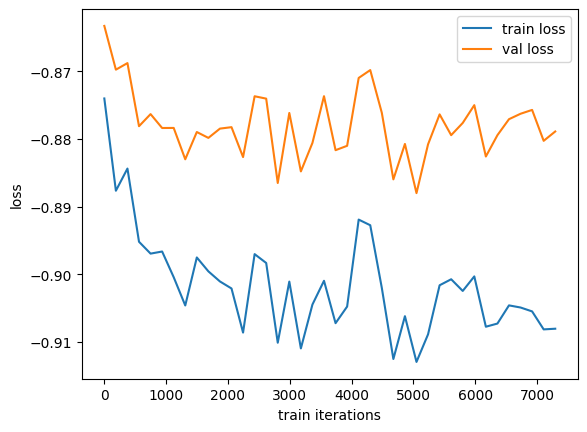

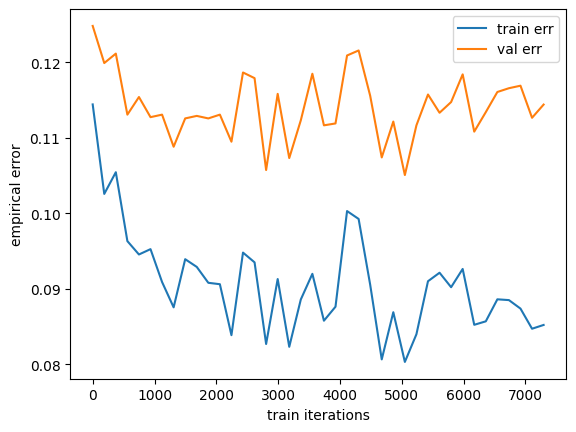

Train err: 0.08523
Validation err: 0.11442
Test err: 0.10500


In [ ]:
xTr, yTr = utils.read_MNIST('training')
xVal, yVal = utils.read_MNIST('validation')
xTe, yTe = utils.read_MNIST('testing')

#### TASK 10 CODE
def get_val_obj(w):
    return np.mean(clf.loss_func(norm_affine_phi(xVal) @ w, yVal))

classifier_kwargs = {
    'phi': norm_affine_phi,
    'is_affine_phi': True,
}

sgd_kwargs = {
    'batch_size': 4,
    'eta': 0.1,
    'n_epochs': 40,
    'verbose': False,
    'loggers': [
        SGDLogger('train_err', get_train_error, None, can_display=True, per_epoch=True),
        SGDLogger('val_err', get_val_error, None, can_display=True, per_epoch=True),
        SGDLogger('val_obj', get_val_obj, None, can_display=True, per_epoch=True),
    ]
}

clf = MultiLogL2Reg(**classifier_kwargs)
clf.fit(xTr, yTr, **sgd_kwargs)

train_err = [logger.log
            for logger in clf.sgd_loggers
            if logger.name == 'train_err']
train_obj = [logger.log
            for logger in clf.sgd_loggers
            if logger.name == 'train_obj']
val_err = [logger.log
            for logger in clf.sgd_loggers
            if logger.name == 'val_err']
val_obj = [logger.log
            for logger in clf.sgd_loggers
            if logger.name == 'val_obj']
print(np.array(train_obj).shape)
plt.figure()
plt.plot(np.arange(sgd_kwargs['n_epochs']) * (len(X) // batch_size), train_obj[0], label=f'train loss')
plt.plot(np.arange(sgd_kwargs['n_epochs']) * (len(X) // batch_size), val_obj[0], label=f'val loss')
plt.ylabel('loss')
plt.xlabel('train iterations')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(sgd_kwargs['n_epochs']) * (len(X) // batch_size), train_err[0], label=f'train err')
plt.plot(np.arange(sgd_kwargs['n_epochs']) * (len(X) // batch_size), val_err[0], label=f'val err')
plt.ylabel('empirical error')
plt.xlabel('train iterations')
plt.legend()
plt.show()

best_clf = clf
#### TASK 10 CODE

train_err = utils.empirical_err(yTr, best_clf.predict(xTr))
val_err = utils.empirical_err(yVal, best_clf.predict(xVal))
test_err = utils.empirical_err(yTe, best_clf.predict(xTe))

print(f'Train err: {train_err:0.5f}')
print(f'Validation err: {val_err:0.5f}')
print(f'Test err: {test_err:0.5f}')